In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case3'
model_name = 'case3_modflow'
model_ws = './models_folder/' + data_folder

Lx = 0.4
Ly = 1.0

nrow = 1
ncol = 80
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

top = 1.0
botm = 0.0

hk = 0.056

nper = 1
perlen = [24,]
nstp = [192,]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc, top=top, botm=botm,
                              nper=nper, perlen=perlen, nstp=nstp, steady=[True,])

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=1, ipakcb=53)

chd_data = {0: [[0, 0, ncol-1, 1.0, 1.0],]}
chd = flopy.modflow.ModflowChd(model, stress_period_data=chd_data)

wel_data = {0: [[0, 0, 0, 0.007]]}
wel = flopy.modflow.ModflowWel(model, ipakcb=66, stress_period_data=wel_data, unitnumber=78)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data, compact=True)
pcg = flopy.modflow.ModflowPcg(model=model)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  1.0


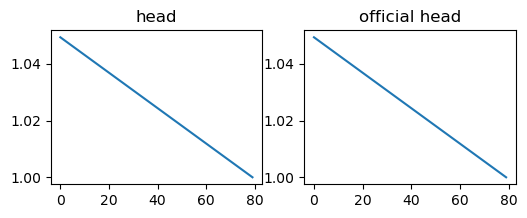

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex03_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(head[-1, 0, 0])
plt.title("head")
plt.subplot(122)
plt.plot(head_official[-1, 0, 0])
plt.title("official head")

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=0,
    ph_ph=0,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/case3\\pht3d_ph.dat'

In [5]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

for i in range(1):
    for key in spec.keys():
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.000492
    wel_spec['ca'] = 0.0108
    wel_spec['cl'] = 0.000119
    wel_spec['mg'] = 0.000969
    wel_spec['na'] = 0.00139
    wel_spec['k'] = 0.000793
    wel_spec['fe'] = 0.0306002
    wel_spec['mn'] = 9.83E-06
    wel_spec['al'] = 0.0043
    wel_spec['si'] = 0.00208
    wel_spec['s6'] = 0.05

    wel_spec['ph'] = 3.938
    wel_spec['pe'] = 7.69

    wel_spec['calcite'] = 0.0
    wel_spec['siderite'] = 0.0
    wel_spec['gypsum'] = 0.0
    wel_spec['sio2a'] = 0.0
    wel_spec['gibbsite'] = 0.0
    wel_spec['feoh3a'] = 0.0

    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0,
  0,
  0,
  0.0,
  2,
  0.000492,
  0.0108,
  0.000119,
  0.000969,
  0.00139,
  0.000793,
  0.0306002,
  9.83e-06,
  0.0043,
  0.00208,
  0.05,
  3.938,
  7.69,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

In [6]:
model_name = 'case3_mt3dms'
icbund = np.abs(ibound)

## Initiate model object
mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 0.35
save_times = np.linspace(0, 24, 25)

## Define FloPy packages
exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp,\
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=1, mxstrn=100000, tsmult=1, timprs=save_times, \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.5, mxpart=100000, nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.005, trpt=0.1, trpv=0.1, multiDiff=True, dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=1, cclose=1.e-12)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

DSP: setting dmcoef for component 2 to zero, kwarg name dmcoef2
DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4
DSP: setting dmcoef for component 5 to zero, kwarg name dmcoef5
DSP: setting dmcoef for component 6 to zero, kwarg name dmcoef6
DSP: setting dmcoef for component 7 to zero, kwarg name dmcoef7
DSP: setting dmcoef for component 8 to zero, kwarg name dmcoef8
DSP: setting dmcoef for component 9 to zero, kwarg name dmcoef9
DSP: setting dmcoef for component 10 to zero, kwarg name dmcoef10
DSP: setting dmcoef for component 11 to zero, kwarg name dmcoef11


In [7]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [8]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO   0.12500    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:  0.1250     Total Elapsed Time:  0.12500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2938      [K,I,J]    1    1   80
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6266E-01  [K,I,J]    1    1   79
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1598E-01  [K,I,J]    1    1   78
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4293E-02  [K,I,J]    1    1   77
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1149E-02  [K,I,J]    1    1   76
 Outer Iter.  1  Inner Iter.  6:  Max

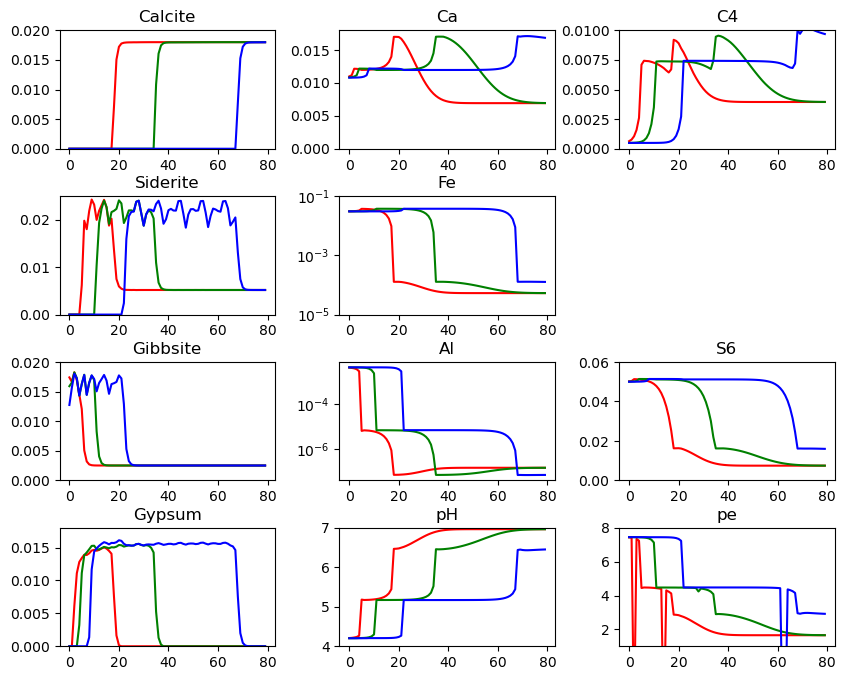

In [9]:
results_c4 = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D001.UCN').get_alldata()
results_ca = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D002.UCN').get_alldata()
results_cl = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D003.UCN').get_alldata()
results_mg = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D004.UCN').get_alldata()
results_na = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D005.UCN').get_alldata()
results_k  = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D006.UCN').get_alldata()
results_fe = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D007.UCN').get_alldata()
results_mn = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D008.UCN').get_alldata()
results_al = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D009.UCN').get_alldata()
results_si = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D010.UCN').get_alldata()
results_s6 = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D011.UCN').get_alldata()
results_ph = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D012.UCN').get_alldata()
results_pe = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D013.UCN').get_alldata()
results_calcite = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D014.UCN').get_alldata()
results_siderite = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D015.UCN').get_alldata()
results_gypsum = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D016.UCN').get_alldata()
results_sio2a = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D017.UCN').get_alldata()
results_gibbsite = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D018.UCN').get_alldata()
results_feoh3a = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D019.UCN').get_alldata()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(4, 3, 1)
ax.plot(results_calcite[6, 0, 0] / 0.35, c="red")
ax.plot(results_calcite[12, 0, 0] / 0.35, c="green")
ax.plot(results_calcite[24, 0, 0] / 0.35, c="blue")
ax.set_title('Calcite')
ax.set_ylim(0.0, 0.02)

ax = fig.add_subplot(4, 3, 2)
ax.plot(results_ca[6, 0, 0], c="red")
ax.plot(results_ca[12, 0, 0], c="green")
ax.plot(results_ca[24, 0, 0], c="blue")
ax.set_title('Ca')
ax.set_ylim(0.0, 0.018)

ax = fig.add_subplot(4, 3, 3)
ax.plot(results_c4[6, 0, 0], c="red")
ax.plot(results_c4[12, 0, 0], c="green")
ax.plot(results_c4[24, 0, 0], c="blue")
ax.set_title('C4')
ax.set_ylim(0.0, 0.010)

ax = fig.add_subplot(4, 3, 4)
ax.plot(results_siderite[6, 0, 0] / 0.35, c="red")
ax.plot(results_siderite[12, 0, 0] / 0.35, c="green")
ax.plot(results_siderite[24, 0, 0] / 0.35, c="blue")
ax.set_title('Siderite') # 菱镁矿
ax.set_ylim(0.0, 0.0250)

ax = fig.add_subplot(4, 3, 5)
ax.plot(results_fe[6, 0, 0], c="red")
ax.plot(results_fe[12, 0, 0], c="green")
ax.plot(results_fe[24, 0, 0], c="blue")
ax.set_title('Fe')
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e-1)

ax = fig.add_subplot(4, 3, 7)
ax.plot(results_gibbsite[6, 0, 0] / 0.35, c="red")
ax.plot(results_gibbsite[12, 0, 0] / 0.35, c="green")
ax.plot(results_gibbsite[24, 0, 0] / 0.35, c="blue")
ax.set_title('Gibbsite')
ax.set_ylim(0.0, 0.02)

ax = fig.add_subplot(4, 3, 8)
ax.plot(results_al[6, 0, 0], c="red")
ax.plot(results_al[12, 0, 0], c="green")
ax.plot(results_al[24, 0, 0], c="blue")
ax.set_title('Al')
ax.set_yscale('log')

ax = fig.add_subplot(4, 3, 9)
ax.plot(results_s6[6, 0, 0], c="red")
ax.plot(results_s6[12, 0, 0], c="green")
ax.plot(results_s6[24, 0, 0], c="blue")
ax.set_title('S6')
ax.set_ylim(0.0, 0.06)

ax = fig.add_subplot(4, 3, 10)
ax.plot(results_gypsum[6, 0, 0] / 0.35, c="red")
ax.plot(results_gypsum[12, 0, 0] / 0.35, c="green")
ax.plot(results_gypsum[24, 0, 0] / 0.35, c="blue")
ax.set_ylim(0.0, 0.018)

ax.set_title('Gypsum')

ax = fig.add_subplot(4, 3, 11)
ax.plot(results_ph[6, 0, 0], c="red")
ax.plot(results_ph[12, 0, 0], c="green")
ax.plot(results_ph[24, 0, 0], c="blue")
ax.set_title('pH')
ax.set_ylim(4.0, 7.0)

ax = fig.add_subplot(4, 3, 12)
ax.plot(results_pe[6, 0, 0], c="red")
ax.plot(results_pe[12, 0, 0], c="green")
ax.plot(results_pe[24, 0, 0], c="blue")
ax.set_title('pe')
ax.set_ylim(1.0, 8.0)


plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.4, wspace=0.3)

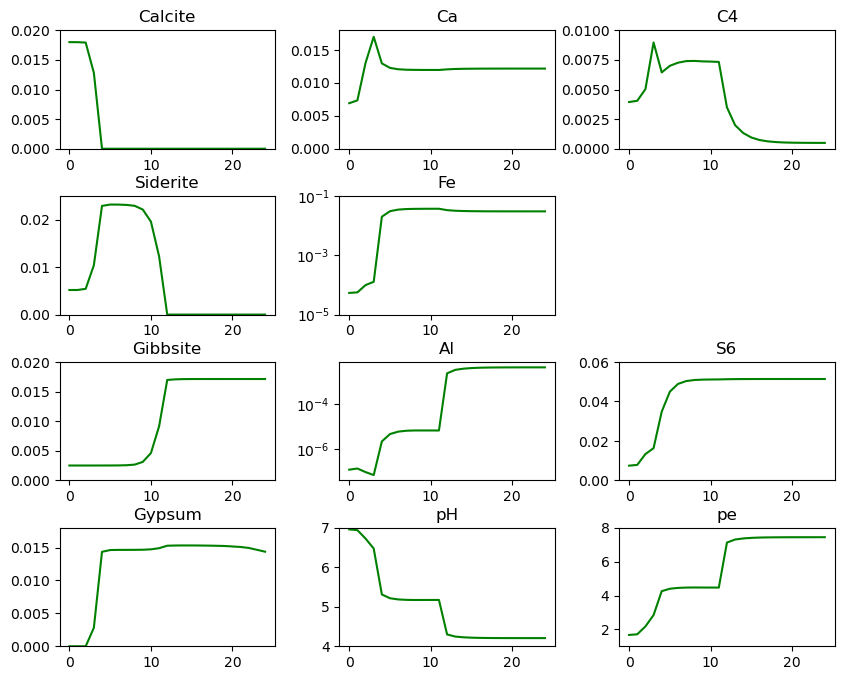

In [12]:
location = 10

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(4, 3, 1)
ax.plot(results_calcite[:, 0, 0, location] / 0.35, c="green")
ax.set_title('Calcite')
ax.set_ylim(0.0, 0.02)

ax = fig.add_subplot(4, 3, 2)
ax.plot(results_ca[:, 0, 0, location], c="green")
ax.set_title('Ca')
ax.set_ylim(0.0, 0.018)

ax = fig.add_subplot(4, 3, 3)
ax.plot(results_c4[:, 0, 0, location], c="green")
ax.set_title('C4')
ax.set_ylim(0.0, 0.010)

ax = fig.add_subplot(4, 3, 4)
ax.plot(results_siderite[:, 0, 0, location] / 0.35, c="green")
ax.set_title('Siderite') # 菱铁矿
ax.set_ylim(0.0, 0.0250)

ax = fig.add_subplot(4, 3, 5)
ax.plot(results_fe[:, 0, 0, location], c="green")
ax.set_title('Fe')
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e-1)

ax = fig.add_subplot(4, 3, 7)
ax.plot(results_gibbsite[:, 0, 0, location] / 0.35, c="green")
ax.set_title('Gibbsite')
ax.set_ylim(0.0, 0.02)

ax = fig.add_subplot(4, 3, 8)
ax.plot(results_al[:, 0, 0, location], c="green")
ax.set_title('Al')
ax.set_yscale('log')

ax = fig.add_subplot(4, 3, 9)
ax.plot(results_s6[:, 0, 0, location], c="green")
ax.set_title('S6')
ax.set_ylim(0.0, 0.06)

ax = fig.add_subplot(4, 3, 10)
ax.plot(results_gypsum[:, 0, 0, location] / 0.35, c="green")
ax.set_ylim(0.0, 0.018)

ax.set_title('Gypsum')

ax = fig.add_subplot(4, 3, 11)
ax.plot(results_ph[:, 0, 0, location], c="green")
ax.set_title('pH')
ax.set_ylim(4.0, 7.0)

ax = fig.add_subplot(4, 3, 12)
ax.plot(results_pe[:, 0, 0, location], c="green")
ax.set_title('pe')
ax.set_ylim(1.0, 8.0)

plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.4, wspace=0.3)